In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score

seed = 1234
np.random.seed(seed)

## Load data

In [16]:
data = pd.read_csv('data/13data.csv')
y = np.array(data[['t1_win']]).ravel()
X = data.drop(['t1_win'], axis = 1)
X = X.to_numpy()

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=seed)
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (25629, 12)
Val: (5492, 12)
Test: (5492, 12)


## Majority Class

In [17]:
mj = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)

print(mj)
print("Final test acc:", mj.score(X_test, y_test))

DummyClassifier(strategy='most_frequent')
Final test acc: 0.5025491624180627


## Logistics Regression

In [18]:
lr = LogisticRegression(
    penalty='l1', solver='saga', max_iter=130, random_state=seed
).fit(X_train, y_train)

print(lr)
print(lr.score(X_test, y_test))

LogisticRegression(max_iter=130, penalty='l1', random_state=1234, solver='saga')
0.7197742170429716


In [19]:
print(lr.coef_)
print(lr.intercept_)

[[-10.7087678  -10.10996256 -10.76486493 -11.54028745 -10.67383134
   10.52237096  12.72094702  11.61637535  11.71752644  12.59622534
    2.05690025  -2.09562718]]
[-2.71858931]


## Decision Tree Classifier

In [20]:
max_depth = [2, 5, 7, 10, 20]
dt_models = []
dt_train_acc = []
dt_val_acc = []

for i in max_depth:
    dt = DecisionTreeClassifier(max_depth=i, random_state=seed)
    dt.fit(X_train, y_train)
    dt_models.append(dt)
    dt_val_acc.append(dt.score(X_val, y_val))
    dt_train_acc.append(dt.score(X_train, y_train))

idx = np.argmax(dt_val_acc)  # index of the model with the highest validation accuracy
dt = dt_models[idx]
test_acc = dt.score(X_test, y_test)

print("Best model index:", idx)
print("Details:", dt)
print("Final test acc:", test_acc)

Best model index: 2
Details: DecisionTreeClassifier(max_depth=7, random_state=1234)
Final test acc: 0.6860888565185724


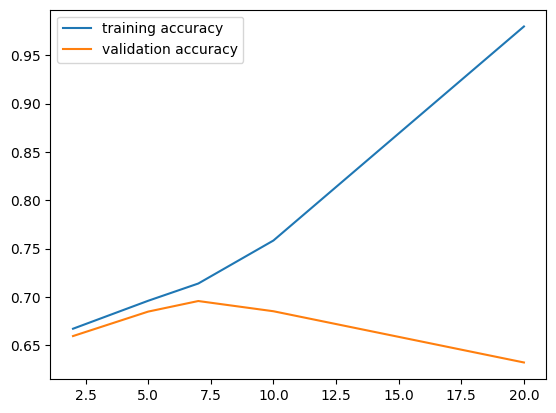

In [21]:
fig, ax = plt.subplots()
ax.plot(max_depth, dt_train_acc, label = 'training accuracy')
ax.plot(max_depth, dt_val_acc, label = 'validation accuracy')
ax.legend()

plt.show()

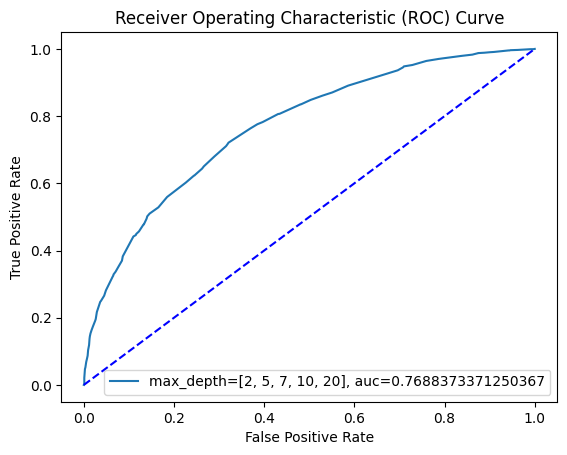

In [22]:
# best dt is defined above
# Get the predicted probabilities and keep probabilities for the positive outcome only
probs = dt.predict_proba(X_val)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, probs)

# Compute Area Under the Curve (AUC)
roc_auc = roc_auc_score(y_val, probs)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'max_depth={max_depth}, auc={roc_auc}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


## Random Forest Classifer

In [23]:
# n_est = [50, 100, 200, 500, 1000]
# rf_models = []
# rf_train_acc = []
# rf_val_acc = []

# for i in n_est:
#     rfc = RandomForestClassifier(n_estimators= i, max_depth=5, random_state=seed)
#     rfc.fit(X_train, y_train)
#     rf_models.append(rfc)
#     rf_val_acc.append(rfc.score(X_val, y_val))
#     rf_train_acc.append(rfc.score(X_train, y_train))

# idx = np.argmax(rf_val_acc)
# rf = rf_models[idx]
# joblib.dump(rf, 'models/rf.joblib')

In [24]:
rf = joblib.load('models/rf.joblib')
test_acc = rf.score(X_test, y_test)

print("Details:", rf)
print("Final test acc:", test_acc)

Details: RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=1234)
Final test acc: 0.6944646758922068


## MLP Classifier

In [25]:
# hidden_layers = [(88,),(88, 88)]
# activation = ['identity', 'logistic', 'tanh']
# mlp_models = []
# mlp_val_acc = []


# for i in activation:
#     for j in hidden_layers:
#         mlp = MLPClassifier(
#             hidden_layer_sizes= j, activation=i, max_iter=300, random_state=seed)
#         mlp.fit(X_train, y_train)
#         mlp_val_acc.append(mlp.score(X_val, y_val))
#         mlp_models.append(mlp)

# idx = np.argmax(mlp_val_acc)
# mlp = mlp_models[idx]
# joblib.dump(mlp, 'models/mlp.joblib')

In [26]:
mlp = joblib.load('models/mlp.joblib')

print("Details:", mlp)
print("Final test acc:", test_acc)

Details: MLPClassifier(activation='logistic', hidden_layer_sizes=(88, 88), max_iter=300,
              random_state=1234)
Final test acc: 0.6944646758922068


## Model comparison

In [27]:
print("Majority class test acc:", mj.score(X_test, y_test))
print("Logistic regression test acc:", lr.score(X_test, y_test))
print("Decision tree test acc:", dt.score(X_test, y_test))
print("Random forest test acc:", rf.score(X_test, y_test))
print("Multi-layer perceptron test acc:", mlp.score(X_test, y_test))

Majority class test acc: 0.5025491624180627
Logistic regression test acc: 0.7197742170429716
Decision tree test acc: 0.6860888565185724
Random forest test acc: 0.6944646758922068
Multi-layer perceptron test acc: 0.7164967225054625


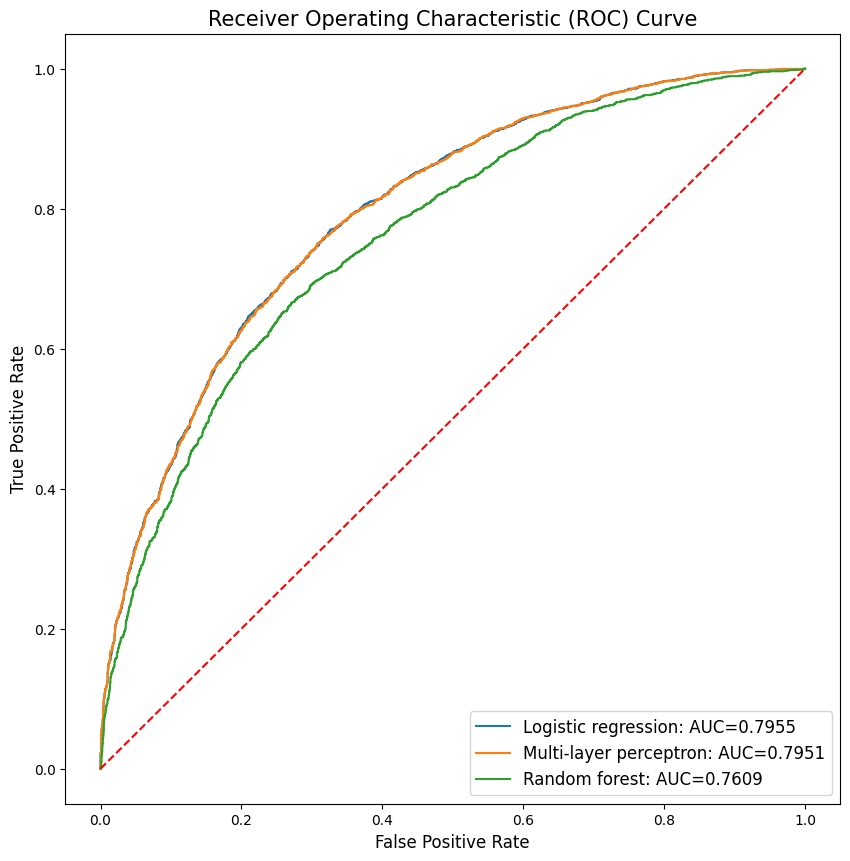

In [28]:
plt.figure(figsize=(10, 10))

# Majority class
# y_pred_proba = mj.predict_proba(X_test)[:,1]
# fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
# auc = roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="Majority class: AUC="+str(round(auc, 4)))

# Logistic Regression
y_pred_proba = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic regression: AUC="+str(round(auc, 4)))

# Multi-layer perceptron
y_pred_proba = mlp.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Multi-layer perceptron: AUC="+str(round(auc, 4)))

# Random forest
y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Random forest: AUC="+str(round(auc, 4)))

# Decision tree
# y_pred_proba = dt.predict_proba(X_test)[:,1]
# fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
# auc = roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="Decision tree: AUC="+str(round(auc, 4)))


plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.ylabel('True Positive Rate', size=12)
plt.xlabel('False Positive Rate', size=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
plt.legend(loc=4, fontsize=12)
plt.show()